In [1]:
import numpy as np
import ot
import matplotlib.pyplot as plt

# Générer des points aléatoires dans le plan euclidien

np.random.seed(42)

In [2]:
import factor_relaxation as fr

In [3]:
def generate_gaussian_mixture(n, centers, std=0.2):
    """
    Génère un mélange de gaussiennes avec plusieurs centres.

    Parameters:
    - n : nombre total de points.
    - centers : liste des centres des gaussiennes (list of tuples).
    - std : écart-type des gaussiennes.

    Returns:
    - points : array (n,2) des coordonnées des points.
    """
    num_clusters = len(centers)
    points = []
    
    for i in range(n):
        center = centers[np.random.randint(num_clusters)]  # Choisir un centre aléatoire
        point = np.random.randn(2) * std + center  # Générer un point autour du centre
        points.append(point)
    
    return np.array(points)

def generate_spiral(n, num_turns=2, noise=0.5):
    """
    Génère une répartition en spirale.

    Parameters:
    - n : nombre de points.
    - num_turns : nombre de tours de la spirale.
    - noise : niveau de bruit ajouté aux points.

    Returns:
    - points : array (n,2) des coordonnées des points.
    """
    # t = np.linspace(0, num_turns * 2 * np.pi, n)  # Paramètre de la spirale
    t = np.random.rand(n) * num_turns * 1.5 * np.pi  # Paramètre de la spirale

    x = t * np.cos(t) + noise * np.random.randn(n)
    y = t * np.sin(t) + noise * np.random.randn(n)
    
    # Normalisation pour que les points restent dans une zone raisonnable
    x = (x - np.min(x)) / (np.max(x) - np.min(x)) * 2 
    y = (y - np.min(y)) / (np.max(y) - np.min(y)) * 2
    
    x = x - np.average(x)
    y = y - np.average(y)
    x=x*2
    y=y*2
    
    return np.vstack((x, y)).T

# Fonction d'affichage du transport optimal
def plot_transport(points_a, points_b, transport_matrix, title, filename):
    """Affiche le transport optimal donné par une matrice de transport."""
    max_transport = np.max(transport_matrix)
    if max_transport > 0:
        transport_matrix /= max_transport  # Normalisation pour l'affichage

    plt.figure(figsize=(8, 6))
    plt.scatter(points_a[:, 0], points_a[:, 1], c='blue', label='Source points (a)')
    plt.scatter(points_b[:, 0], points_b[:, 1], c='red', label='Target points (b)')

    # Afficher les connexions entre points selon transport_matrix
    for i in range(len(points_a)):
        for j in range(len(points_b)):
            if transport_matrix[i, j] > 1e-3:  # Seuil pour éviter trop de traits
                # line_width = 5 * transport_matrix[i, j]  # Épaisseur proportionnelle au transport
                alpha_value = transport_matrix[i, j]  # Opacité proportionnelle
                plt.plot([points_a[i, 0], points_b[j, 0]], [points_a[i, 1], points_b[j, 1]], 
                         'black', alpha=alpha_value, linewidth=1)

    plt.legend()
    plt.title(title)
    #plt.savefig(filename)  # Sauvegarde de l'image
    plt.show()

def plot_loss(loss_liste, title, filename):
    """
    Affiche et sauvegarde l'évolution de la loss pendant l'optimisation.

    Parameters:
    - loss_liste : liste des valeurs de la loss à chaque itération.
    - title : titre du graphique.
    - filename : nom du fichier pour sauvegarder l'image.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(loss_liste, label="Loss", color="blue")
    plt.xlabel("Itération")
    plt.ylabel("Loss")
    plt.yscale("log")  # Échelle logarithmique pour mieux voir la convergence
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    #plt.savefig(filename)  # Sauvegarde de l'image
    plt.show()


def generate_points(n, m, d, sigma):
    """
    Génère n points distribués uniformément sur les faces d'un hypercube de dimension d
    et m points distribués selon une gaussienne centrée au centre de l'hypercube.

    Paramètres :
    n (int) : Nombre de points à générer sur les faces de l'hypercube.
    m (int) : Nombre de points à générer selon une distribution gaussienne.
    d (int) : Dimension de l'hypercube.
    sigma (float) : Écart-type pour la distribution gaussienne.

    Retourne :
    tuple : Un tuple contenant deux tableaux numpy :
            - Le premier tableau contient les points sur les faces de l'hypercube.
            - Le second tableau contient les points distribués selon une gaussienne.
    """
    # Générer n points sur les faces de l'hypercube
    face_points = np.random.rand(n, d)
    for i in range(n):
        num_fixed_dims = np.random.randint(1, d + 1)
        fixed_dims = np.random.choice(d, num_fixed_dims, replace=False)
        for dim in fixed_dims:
            face_points[i, dim] = np.random.choice([0, 1])

    # Générer m points selon une distribution gaussienne
    mean = [0.5] * d  # Centre de l'hypercube
    cov = (sigma ** 2) * np.eye(d)  # Matrice de covariance
    gaussian_points = np.random.multivariate_normal(mean, cov, m)

    return face_points, gaussian_points

In [4]:
n, m = 500, 50  # Nombre de points dans a et b

centers_a = [(-2, -1.5), (-2, 0), (-2, 2)]
centers_b = [(2, -1), (2, 1)]

points_a = generate_gaussian_mixture(n, centers_a)
points_b = generate_gaussian_mixture(m, centers_b)

# Calculer la matrice de coût (distance euclidienne)
cost_matrix = np.linalg.norm(points_a[:, None, :] - points_b[None, :, :], axis=2)

# Générer des distributions de poids
distrib_a = np.array([1/n]*n)
distrib_b = np.array([1/m]*m)

r = 5
tau = 10
gamma = 10
delta = 1e-12
epsilon = 1e-9
max_iter = 100

# COMPARAISON : 

In [5]:
kantorovich_loss, kantorovich_sol_dic = ot.emd2(distrib_a, distrib_b, cost_matrix, return_matrix=True, check_marginals=False)
print(kantorovich_sol_dic.keys())
kantorovich_sol = kantorovich_sol_dic['G']

print(kantorovich_loss)

dict_keys(['G', 'u', 'v', 'warning', 'result_code'])
4.001696825734433


In [6]:
Q, T, R_transpose, loss_liste, _ = fr.solve_balanced_FRLC(
    C=cost_matrix, 
    r=r, 
    a=distrib_a, 
    b=distrib_b, 
    tau=tau, 
    gamma=gamma, 
    delta=delta, 
    epsilon=epsilon, 
    max_iter=max_iter
)

transport_matrix_frlc= Q@T@R_transpose

In [7]:
def norme(v):
    return np.sqrt(np.sum(v**2))

# print(np.sqrt(np.sum(((np.ones(n) @ transport_matrix_frlc)-distrib_b)**2)))
# print(np.sqrt(np.sum(((transport_matrix_frlc @ np.ones(m))-distrib_a)**2)))

# Marginale Q
print(norme(Q @ np.ones(r) - distrib_a))

print(norme((R_transpose.T @ np.ones(r)-distrib_b)))
print(norme(T @ np.ones(r)-Q.T @ np.ones(n)))

print(norme(T.T @ np.ones(r) - R_transpose @ np.ones(m)))




4.3330691907774544e-08
9.644852256336432e-08
2.4406907395502495e-07
0.0


gamma:10, tau:10 [np.float64(4.310095330564424), np.float64(4.309991498252001), np.float64(4.3096584721171975), np.float64(4.308487447277332), np.float64(4.303708142569189), np.float64(4.281927033420079), np.float64(4.216951877383851), np.float64(4.1429952638057825), np.float64(4.108350373440785), np.float64(4.089968891989011), np.float64(4.074560295301264), np.float64(4.061431738872001), np.float64(4.053073112708046), np.float64(4.048198849217578), np.float64(4.045231345183438), np.float64(4.043431766308651), np.float64(4.042312427216076), np.float64(4.041536388731207), np.float64(4.040909596121258), np.float64(4.040343538119934), np.float64(4.039809177711255), np.float64(4.039300369536024), np.float64(4.0388124300826025), np.float64(4.0383361794599795), np.float64(4.037859931420158), np.float64(4.037372763688528), np.float64(4.036866615474527), np.float64(4.036336125829146), np.float64(4.035777736958528), np.float64(4.03518944436357), np.float64(4.034569916936453), np.float64(4.03391

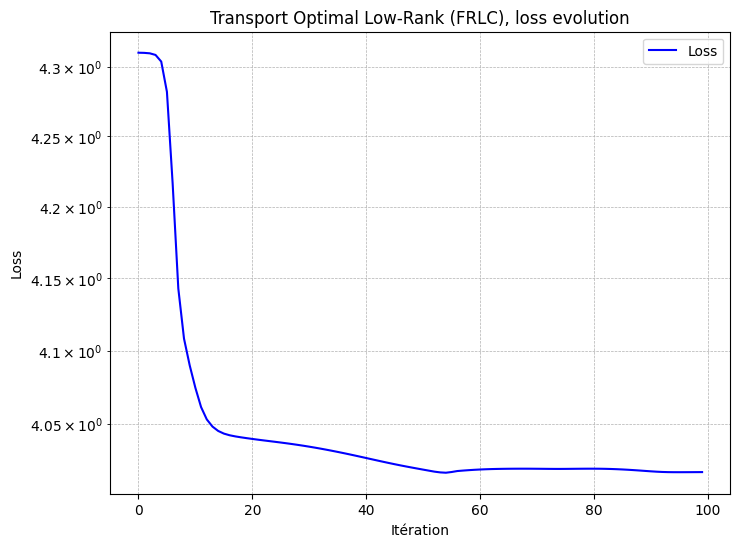

ploted


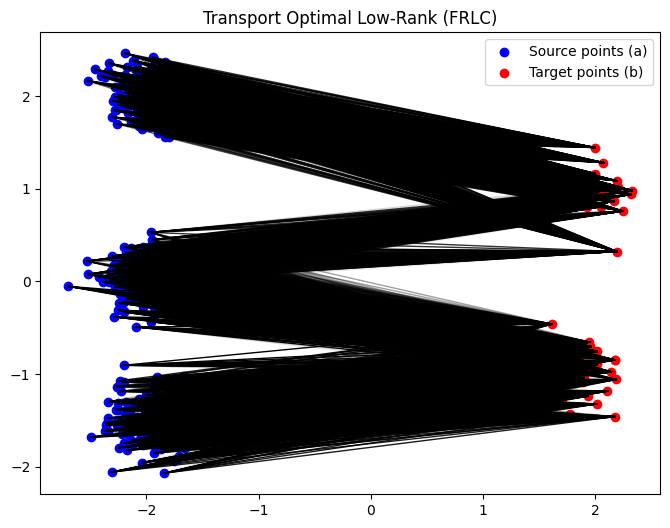

ploted*2


In [8]:
print(f"gamma:{gamma}, tau:{tau}", loss_liste)
plot_loss(loss_liste, "Transport Optimal Low-Rank (FRLC), loss evolution", f"./output/loss_transport_frlc_tau_{tau}.png")
print("ploted")
plot_transport(points_a, points_b, transport_matrix_frlc, "Transport Optimal Low-Rank (FRLC)", f"./output/transport_frlc_tau_{tau}.png")
print("ploted*2")